In [55]:
import numpy as np
from tqdm import trange, tqdm
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

## Synthetic data

In [421]:
mu, std = -2, .2

In [455]:
generator = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
).cuda()

discriminator = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
).cuda()

In [456]:
d_real_losses = []
d_fake_losses = []
g_losses = []
decisions = []
maps = []

In [465]:
lr = 1e-6
g_opt = torch.optim.Adam(generator.parameters(), lr=lr)
d_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [458]:
criterion = nn.BCELoss()

In [459]:
epochs = 2000
batch_size = 100

In [466]:
for epoch in trange(epochs):
    fake = generator(Variable(torch.rand(1000, 1)).cuda())
    fake = fake.cpu().data[:, 0].numpy()
    bound = discriminator(Variable(torch.range(-3 + mu, 3 + mu, .01)).cuda().view(-1, 1))
    bound = bound.cpu().data[:, 0].numpy()
    maps.append(fake)
    decisions.append(bound)
    
    for _ in range(10):
        discriminator.zero_grad()
        real = Variable(torch.normal(mu * torch.ones(batch_size, 1), std)).cuda()
        labels = Variable(torch.ones(batch_size, 1)).cuda()
        y = discriminator(real)
        loss = criterion(y, labels)

        fake = Variable(torch.rand(batch_size, 1)).cuda()
        y = discriminator(generator(fake))
        labels = Variable(torch.zeros(batch_size, 1)).cuda()
        loss_fake = criterion(y, labels)

        d_real_losses.append(loss.cpu().data.numpy()[0])
        d_fake_losses.append(loss_fake.cpu().data.numpy()[0])

        loss += loss_fake
        loss.backward()
        d_opt.step()
    
    generator.zero_grad()
    fake = Variable(torch.rand(batch_size, 1)).cuda()
    y = discriminator(generator(fake))
    labels = Variable(torch.ones(batch_size, 1)).cuda()
    loss = criterion(y, labels)
    
    g_losses.append(loss.cpu().data.numpy()[0])
    
    loss.backward()
    g_opt.step()

100%|██████████| 2000/2000 [02:22<00:00, 12.37it/s]


In [96]:
from matplotlib import pyplot as plt
from matplotlib import mlab
%matplotlib inline

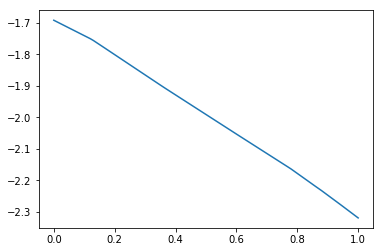

In [469]:
x = generator(Variable(torch.range(0, 1, .01)).cuda().view(-1, 1))
plt.plot(np.arange(0, 1.0001, .01), x.cpu().data[:, 0].numpy())

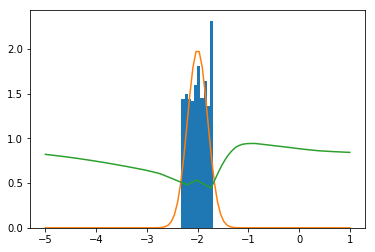

In [467]:
fake = generator(Variable(torch.rand(1000, 1)).cuda())
fake = fake.cpu().data[:, 0].numpy()
bound = discriminator(Variable(torch.range(-3 + mu, 3 + mu, .01)).cuda().view(-1, 1))
bound = bound.cpu().data[:, 0].numpy()

plt.hist(fake, normed=True)
x = np.linspace(-3 + mu, 3 + mu, 100)
plt.plot(x,mlab.normpdf(x, mu, std))
x = np.linspace(-3 + mu, 3 + mu, 601)
plt.plot(x, bound)

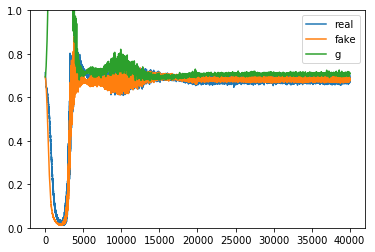

In [470]:
plt.ylim((None, 1))
plt.plot(d_real_losses, label='real')
plt.plot(d_fake_losses, label='fake')
x = np.linspace(0, len(d_real_losses), len(g_losses))
plt.plot(x, g_losses, label='g')
plt.legend()

## MNIST

In [471]:
import sys
import os
import numpy as np

def load_dataset():
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [472]:
def minibatches(inputs, targets, batch_size, shuffle=True, strict=True):
    assert len(inputs) == len(targets)

    last = batch_size - 1 if strict else 0
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - last, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]

In [757]:
class View(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, input):
        return input.view(*self.shape)

gen_space = 40
generator = nn.Sequential(
    nn.Linear(gen_space, 200),
    nn.ReLU(),
#     nn.Linear(100, 300),
#     nn.ReLU(),
    nn.Linear(200, 5 ** 2 * 16),
    nn.ReLU(),
    View(-1, 16, 5, 5),
    nn.UpsamplingNearest2d(scale_factor=2), # 10
    nn.ConvTranspose2d(16, 8, 4), # 13
    nn.ReLU(),
    nn.UpsamplingNearest2d(scale_factor=2), # 26
#     nn.ConvTranspose2d(12, 4, 2), # 1
#     nn.ReLU(),
#     nn.UpsamplingNearest2d(scale_factor=2), # 26
    nn.ConvTranspose2d(8, 1, 3), # 28
    nn.Sigmoid(),
).cuda()

discriminator = nn.Sequential(
    nn.Conv2d(1, 8, 3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(8, 16, 3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    View(-1, 5 ** 2 * 16),
    nn.Linear(5 ** 2 * 16, 40),
    nn.ReLU(),
    nn.Linear(40, 1),
    nn.Sigmoid(),
).cuda()

d_real_losses = []
d_fake_losses = []
g_losses = []

In [758]:
lr = 1e-6
g_opt = torch.optim.Adam(generator.parameters(), lr=lr)
d_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

In [774]:
epochs = 10
batch_size = 200

In [775]:
for epoch in trange(epochs):
    for _ in range(3):
        temp_real = temp_fake = steps = 0
        for x, _ in minibatches(X_train, y_train, batch_size=batch_size):
            discriminator.zero_grad()
            
            real = Variable(torch.from_numpy(x)).cuda()
            y = discriminator(real)
            labels = Variable(torch.ones(batch_size, 1)).cuda()
            loss = criterion(y, labels)

            fake = Variable(torch.normal(torch.zeros(batch_size, gen_space), 1)).cuda()
            y = discriminator(generator(fake))
            labels = Variable(torch.zeros(batch_size, 1)).cuda()
            loss_fake = criterion(y, labels)

            temp_real += loss.cpu().data.numpy()[0]
            temp_fake += loss_fake.cpu().data.numpy()[0]
            steps += 1

            loss += loss_fake
            loss.backward()
            d_opt.step()
    
        d_real_losses.append(temp_real / steps)
        d_fake_losses.append(temp_fake / steps)
    
    for _ in range(3):
        temp = steps = 0
        for x, _ in minibatches(X_train, y_train, batch_size=batch_size):
            generator.zero_grad()

            fake = Variable(torch.normal(torch.zeros(batch_size, gen_space), 1)).cuda()
            y = discriminator(generator(fake))
            labels = Variable(torch.ones(batch_size, 1)).cuda()
            loss = criterion(y, labels)

            temp += loss.cpu().data.numpy()[0]
            steps += 1

            loss.backward()
            g_opt.step()

        g_losses.append(temp / steps)

100%|██████████| 10/10 [02:35<00:00, 15.66s/it]


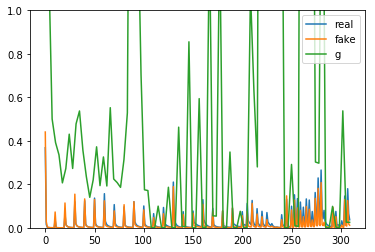

In [776]:
plt.ylim((None, 1))
plt.plot(d_real_losses, label='real')
plt.plot(d_fake_losses, label='fake')
x = np.linspace(0, len(d_real_losses)-1, len(g_losses))
plt.plot(x, g_losses, label='g')
plt.legend()

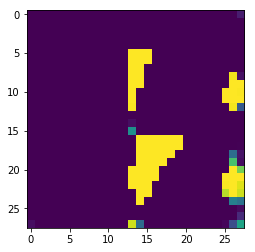

In [777]:
fake = generator(Variable(torch.ones(1, gen_space)).cuda())
fake = fake.cpu().data[0, 0].numpy()
plt.imshow(fake)

In [625]:
torch.save(discriminator, 'gan_40/discriminator')
torch.save(generator, 'gan_40/generator')

/home/mount/neuro-t01-ssd/home/memax/env36/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type View. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
